In [ ]:
import random

with open("seeds.txt", "w") as file:
    for i in range(5000):
        file.write(str(random.randint(0, 2**64)) + "\n")

# Load cubiomes data

In [2]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dataclasses import asdict
from typing import Literal
import json
import random

from data import World


def convert_cubiome_to_csv(cubiome_export_path, type: Literal["biomes", "structures"]):
    df = pd.read_csv(
        cubiome_export_path,
        header=6 if type == "biomes" else 5,
        sep=";",
    )

    return df


In [3]:
biomes = convert_cubiome_to_csv("biomes.txt", type="biomes")
structures = convert_cubiome_to_csv("structures.txt", type="structures")

In [4]:
ALL_BIOMES = biomes.columns[1:]
ALL_STRUCTURES = structures.structure.unique()
ALL_SEEDS = structures.seed.unique()

# Convert DataFrame representation to something easier to work with 

In [5]:
worlds = []

for seed in tqdm(ALL_SEEDS):
    world = World(seed)
    subs_structs = structures[structures["seed"] == seed]
    subs_biomes = biomes[biomes["seed"] == seed]

    if subs_biomes.empty or subs_structs.empty:
        continue
    for kind, count in subs_biomes.T.iloc[2:, :].itertuples():
        world.add_biome(kind, count)

    for _, _, kind, x, z, details in subs_structs.itertuples():
        world.add_structure(kind, x, z, details)

    worlds.append(world)

del biomes, structures

100%|██████████| 1773/1773 [01:22<00:00, 21.44it/s]


# Find best seed

For a seed $s_i \in S$, with $c_{ij}$ instances of a structure $t_j \in T$, the score is given by the sum of Z-scores for each structure. 

$$
    S = \{s_1, s_2, s_3, \dots, s_n\} \\
    T = \{t_1, t_2, t_3, \dots, t_m\} \\
    \text{score}\left(s_i\right) = \sum^m_{j=1} \hat{c}_{ij} \\ 
    \hat{c}_{ij} = \frac{c_{ij} - \mu_{j}}{\sigma_{j}} \\ 
$$

Where $\mu_j$ and $\sigma_j$ are the mean and variance in the count of structure $t_j$ across all world seeds. 

Therefore, the best seed $s^{*}$ is given by the world with the highest score. 

$$
s^{*} = \underset{i}{\text{arg\,max}}~\text{score}\left(s_i\right)
$$

In [6]:
from scipy.stats import norm

dist = {}

for structure in tqdm(ALL_STRUCTURES):
    counts = []
    for world in worlds:
        counts.append(world.get_structure_count(structure))
    mean, std = norm.fit(counts)
    dist[structure] = dict(mean=mean, std=std)

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


In [75]:
def score(world, weights=None):
    score = 0
    for structure in ALL_STRUCTURES:
        if structure == "spawn":
            continue
        z = (world.get_structure_count(structure) - dist[structure]["mean"]) / dist[
            structure
        ]["std"]

        if weights is not None:
            z *= weights[structure]

        score += z

    return score


weights = {
    "mansion": 2,
    "spawn": 0,
    "swamp_hut": 2,
    "stronghold": 5,
    "jungle_pyramid": 0.5,
    "pillager_outpost": 0.5,
    "desert_pyramid": 0.5,
    "desert_well": 0.5,
    "igloo": 1,
    "ancient_city": 5,
    "trail_ruins": 0.5,
    "monument": 2,
    "village": 2,
    "buried_treasure": 0.5,
    "shipwreck": 0.5,
    "ruined_portal": 0.5,
    "ocean_ruin": 0.5,
    "trial_chambers": 2,
    "mineshaft": 1,
    "amethyst_geode": 0.1,
}
scores = {world.seed: score(world, weights) for world in worlds}

In [67]:
scores = dict(sorted(scores.items(), key=lambda x: x[1]))

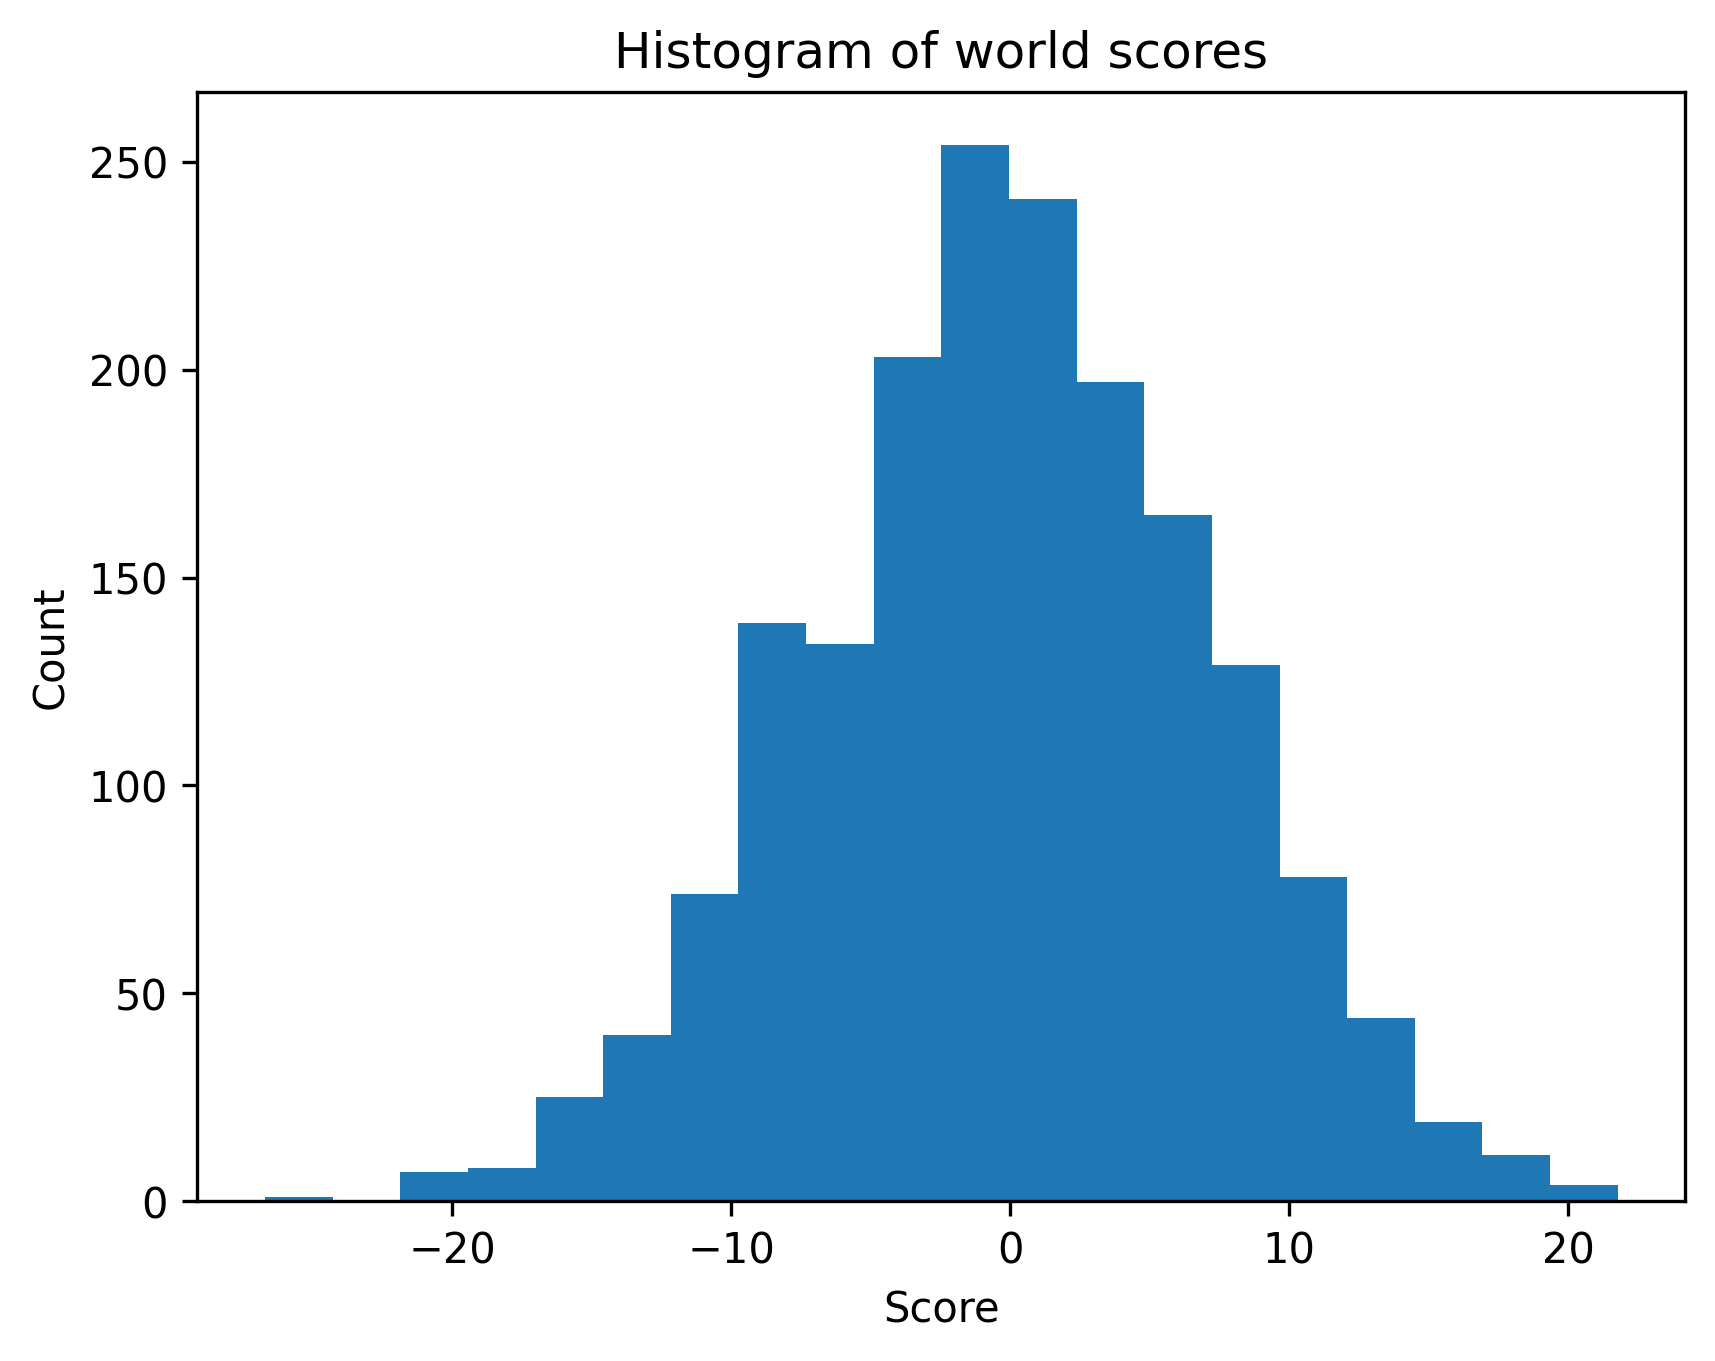

In [68]:
plt.figure(dpi=300)
plt.title("Histogram of world scores")
plt.hist(list(scores.values()), bins=20)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [69]:
best_seed = list(scores.keys())[-1]
best_world = [world for world in worlds if world.seed == best_seed][0]

In [70]:
spawn = list(filter(lambda s: s.kind == "spawn", best_world.structures))[0]

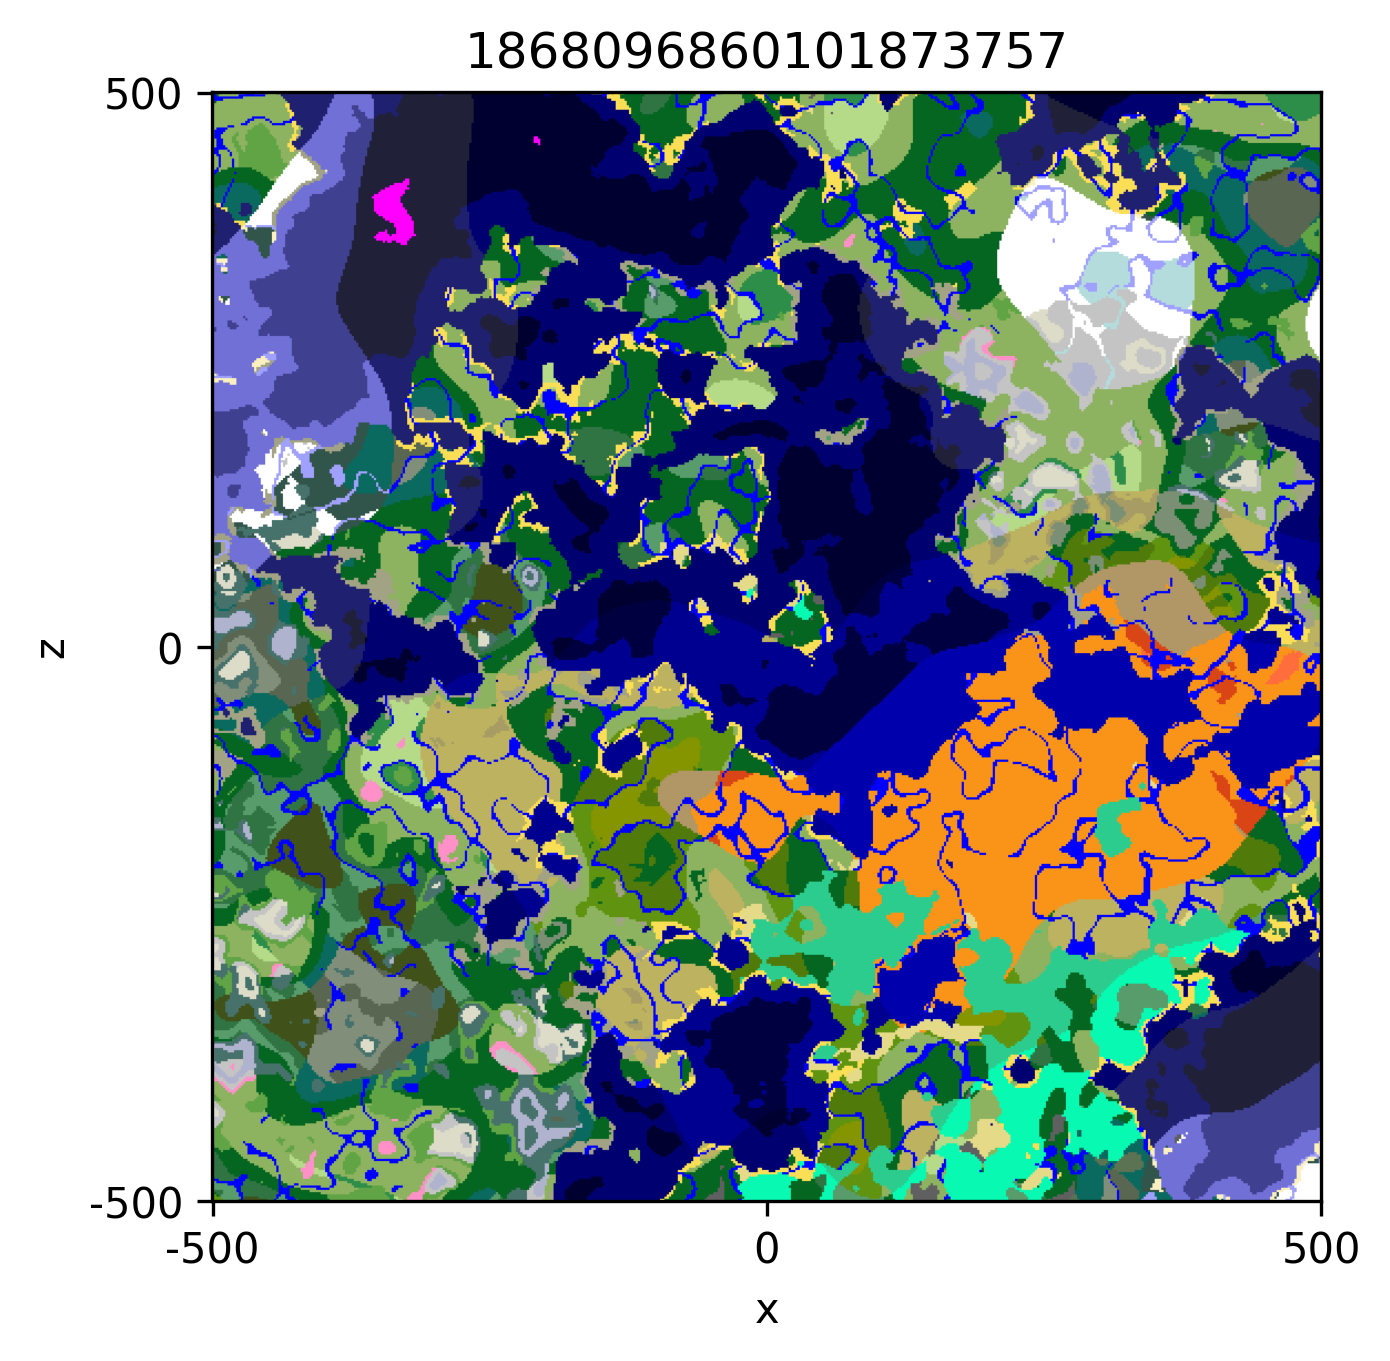

In [71]:
img = best_world.generate_image()

plt.figure(dpi=300)
plt.title(best_world.seed)
plt.imshow(img)
plt.xticks([0, 1000, 2000], [-500, 0, 500])
plt.xlabel("x")
plt.yticks([0, 1000, 2000], [500, 0, -500])
plt.ylabel("z")
plt.show()

In [ ]:
df = {"structure": [], "count": [], "z-score": [], "weighted-score": []}
for structure in ALL_STRUCTURES:
    if structure == "spawn":
        continue

    df["structure"].append(structure)
    df["count"].append(best_world.get_structure_count(structure))
    df["z-score"].append(
        (df["count"][-1] - dist[structure]["mean"]) / dist[structure]["std"]
    )
    df["weighted-score"].append(df["z-score"][-1] * weights[structure])

df = pd.DataFrame(df).sort_values("z-score", ascending=False)
df

,structure,count,z-score
8,ancient_city,46,2.695428
10,monument,54,1.707027
15,ocean_ruin,367,1.683961
13,shipwreck,269,1.507624
2,stronghold,8,1.466586
4,pillager_outpost,18,1.362879
1,swamp_hut,7,0.928910
7,igloo,27,0.609346
5,desert_pyramid,10,0.449945
6,desert_well,13,0.294688


In [73]:
best_world.seed

1868096860101873757

In [74]:
pd.DataFrame(dist).round(2)

,mansion,spawn,swamp_hut,stronghold,jungle_pyramid,pillager_outpost,desert_pyramid,desert_well,igloo,ancient_city,trail_ruins,monument,village,buried_treasure,shipwreck,ruined_portal,ocean_ruin,trial_chambers,mineshaft,amethyst_geode
mean,1.78,1.0,4.31,6.69,9.13,12.95,7.50,10.74,19.42,21.92,37.28,35.92,81.75,105.82,219.54,245.91,290.08,322.50,1562.38,16278.92
std,0.92,0.0,2.90,0.89,4.14,3.71,5.55,7.68,12.44,8.94,8.64,10.59,10.86,18.35,32.80,2.55,45.68,6.03,54.24,122.82
